In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def load_all_batches(source_folder, num_batches):
    all_images = []
    all_labels = []
    for i in range(num_batches):
        image_path = os.path.join(source_folder, f'processed_images_batch_{i}.npy')
        label_path = os.path.join(source_folder, f'processed_labels_batch_{i}.npy')
        if not os.path.exists(image_path) or not os.path.exists(label_path):
            print(f"Batch {i} not found, skipping.")
            continue
        images = np.load(image_path)
        labels = np.load(label_path)
        all_images.append(images)
        all_labels.append(labels)
    X = np.concatenate(all_images, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

# Set the folder path where your filtered data is saved and the total number of batches.
data_folder = '/Users/issackondreddy/Desktop/Programming/ML Project/Lung Cancer Detection/data/processed_images_by_filter'
num_batches = 10  # Adjust according to your actual number of batches

X, y = load_all_batches(data_folder, num_batches)
print("Loaded data shapes:", X.shape, y.shape)


Loaded data shapes: (160, 224, 224) (160,)


In [3]:
# EfficientNetB0 default input size is 224x224x3.
target_size = (224, 224)

def preprocess_images(images):
    processed = []
    for img in images:
        # If image is 2D (grayscale), convert to 3 channels.
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.shape[-1] == 1:
            img = np.concatenate([img]*3, axis=-1)
        # Resize image using tf.image.resize
        img_resized = tf.image.resize(img, target_size).numpy()
        processed.append(img_resized)
    processed = np.array(processed)
    # Normalize to [0, 1]
    processed = processed.astype(np.float32) / 255.0
    # Apply EfficientNet preprocessing (scaling input to range as expected by the model)
    processed = preprocess_input(processed)
    return processed

X_processed = preprocess_images(X)
print("Processed images shape:", X_processed.shape)

# Split data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, y_train.shape, "Val:", X_val.shape, y_val.shape)

Processed images shape: (160, 224, 224, 3)
Train: (128, 224, 224, 3) (128,) Val: (32, 224, 224, 3) (32,)


In [12]:
num_classes = len(np.unique(y))  # Adjust if needed

# Build the model using EfficientNetB0 as the base.
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 256)               327936    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [13]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/20
4/4 [==============================] - 4s 635ms/step - loss: 1.1116 - accuracy: 0.3516 - val_loss: 1.0909 - val_accuracy: 0.3438
Epoch 2/20
4/4 [==============================] - 2s 444ms/step - loss: 1.1006 - accuracy: 0.3672 - val_loss: 1.0797 - val_accuracy: 0.3438
Epoch 3/20
4/4 [==============================] - 2s 487ms/step - loss: 1.0984 - accuracy: 0.3672 - val_loss: 1.0708 - val_accuracy: 0.3438
Epoch 4/20
4/4 [==============================] - 2s 443ms/step - loss: 1.1058 - accuracy: 0.3672 - val_loss: 1.0816 - val_accuracy: 0.3438
Epoch 5/20
4/4 [==============================] - 2s 427ms/step - loss: 1.0965 - accuracy: 0.3672 - val_loss: 1.0994 - val_accuracy: 0.3438
Epoch 6/20
4/4 [==============================] - 2s 426ms/step - loss: 1.0992 - accuracy: 0.3672 - val_loss: 1.0926 - val_accuracy: 0.3438
Epoch 7/20
4/4 [==============================] - 2s 431ms/step - loss: 1.1004 - accuracy: 0.3672 - val_loss: 1.0999 - val_accuracy: 0.3438
Epoch 8/20
4/4 [====

1/1 [==============================] - 0s 364ms/step - loss: 1.1029 - accuracy: 0.3438
Validation Loss: 1.1028903722763062 Validation Accuracy: 0.34375


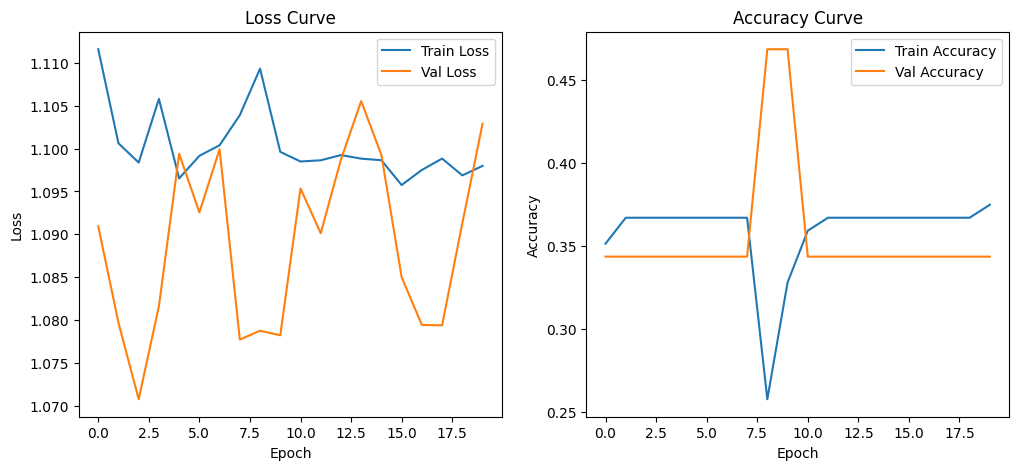

In [14]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss, "Validation Accuracy:", val_accuracy)

# Plot training history.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()